In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from ETL import ETL
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import numpy as np
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import DBSCAN
import seaborn as sns
from sklearn.neighbors import NearestNeighbors

In [2]:
df = pd.read_csv('dataset/flights.csv')

In [3]:
df = ETL(df)

c:\Users\dswal\Desktop\Data-Science-Project\ETL.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'FL_MON'] = df['FL_DATE'].apply(lambda x: x.month)
c:\Users\dswal\Desktop\Data-Science-Project\ETL.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'FL_DAY'] = df['FL_DATE'].apply(lambda x: x.day)
c:\Users\dswal\Desktop\Data-Science-Project\ETL.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

# PCA

In [37]:
df.columns

Index(['OP_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST', 'CRS_DEP_TIME',
       'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON',
       'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'CANCELLED',
       'DIVERTED', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME',
       'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY',
       'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'FL_MON', 'FL_DAY', 'FL_YEAR',
       'FL_DOW', 'CRS_DEP_HOUR', 'CRS_DEP_MIN', 'ACTUAL_TO_CRS_ELAPSED_RATIO',
       'CANCELLATION_REASON', 'IS_HOLIDAY'],
      dtype='object')

In [4]:
filtered_data = df[(df['CANCELLED'] == 0) & (df['DIVERTED'] == 0)]
data = filtered_data[['DEP_DELAY', 'ARR_DELAY', 
                    'TAXI_OUT', 'TAXI_IN',
                    'ACT_TO_CRS_RATIO']].fillna(0)


In [5]:
# Standardizzazione dei dati
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

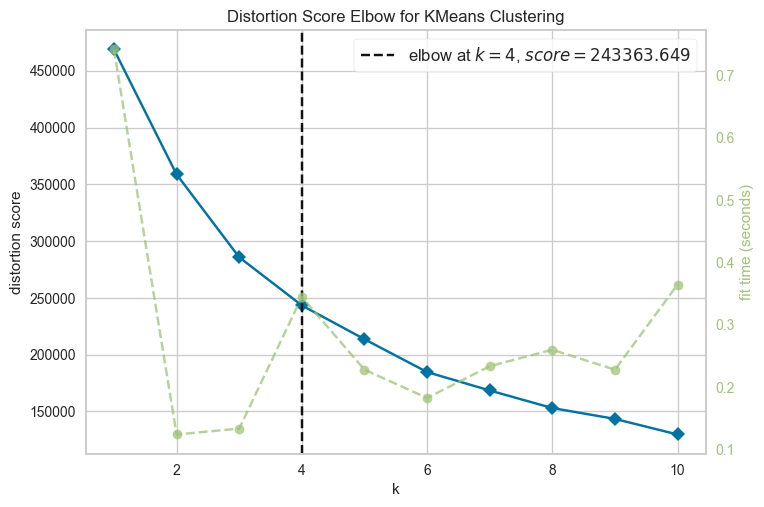

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [6]:
# Creazione del modello KMeans
model = KMeans(random_state=42)

# Utilizzo di KElbowVisualizer per determinare il numero ottimale di cluster
visualizer = KElbowVisualizer(model, k=(1, 11), metric='distortion', timings=True)

# Fit dei dati e visualizzazione del grafico
visualizer.fit(data_scaled)
visualizer.show()

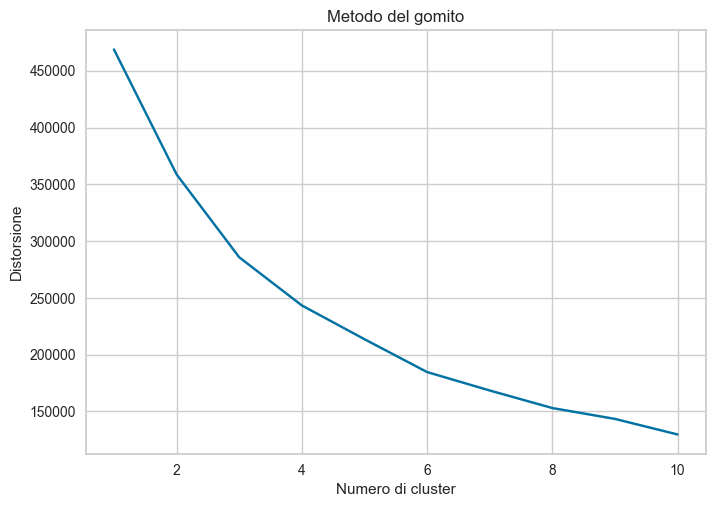

In [26]:
distortions = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(data_scaled)
    distortions.append(kmeans.inertia_)

plt.plot(range(1, 11), distortions)
plt.xlabel('Numero di cluster')
plt.ylabel('Distorsione')
plt.title('Metodo del gomito')
plt.show()

Numero ottimale di cluster secondo il metodo del gomito: 4


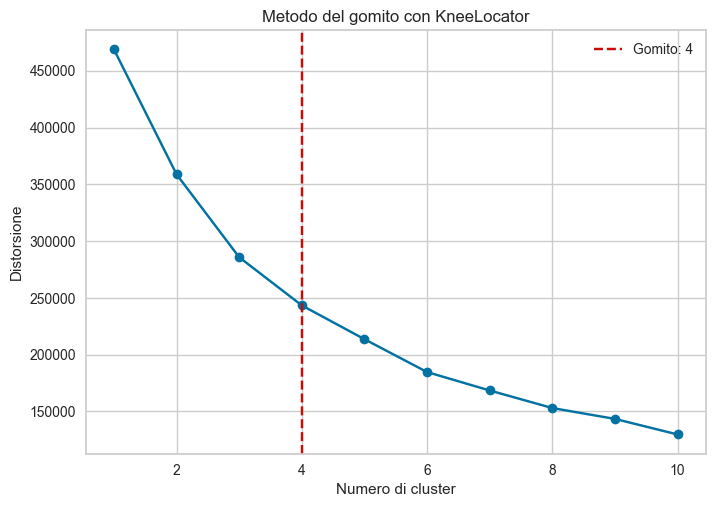

In [27]:
# Calcolare il "gomito"
knee = KneeLocator(range(1, 11), distortions, curve="convex", direction="decreasing")

# Stampare e visualizzare il risultato
print(f"Numero ottimale di cluster secondo il metodo del gomito: {knee.knee}")

# Modificare il grafico per evidenziare il gomito
plt.plot(range(1, 11), distortions, marker='o')
plt.axvline(x=knee.knee, color='r', linestyle='--', label=f"Gomito: {knee.knee}")
plt.xlabel('Numero di cluster')
plt.ylabel('Distorsione')
plt.title('Metodo del gomito con KneeLocator')
plt.legend()
plt.show()


In [7]:
pca = PCA(n_components=2)  # Sostituisci 2 con il numero di componenti che vuoi
pca_result = pca.fit_transform(data_scaled)

In [13]:
# Applica K-Means ai risultati della PCA
kmeans = KMeans(n_clusters=3, random_state=0)  # Imposta n_clusters al numero desiderato
kmeans.fit(pca_result)
clusters = kmeans.predict(pca_result)

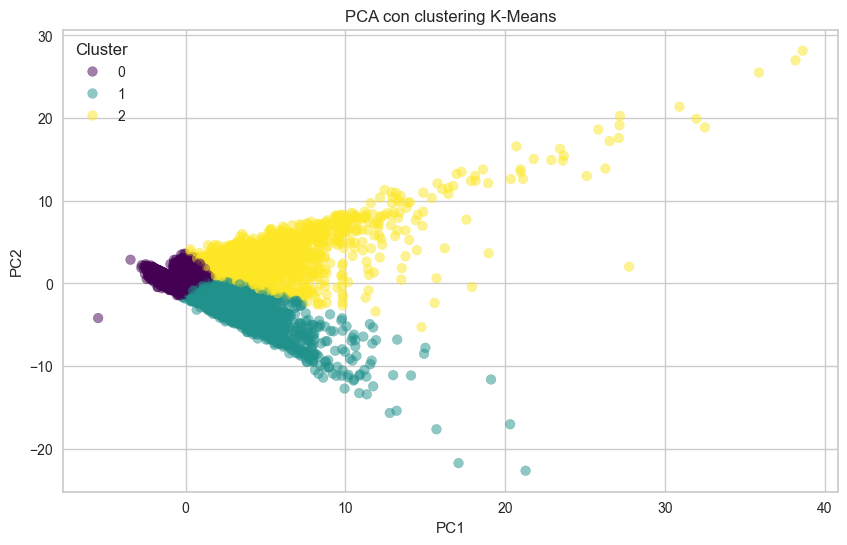

In [21]:
# Visualizza il grafico della PCA con i cluster di K-Means
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA con clustering K-Means')
plt.legend(*scatter.legend_elements(), title="Cluster", loc='best')
plt.show()

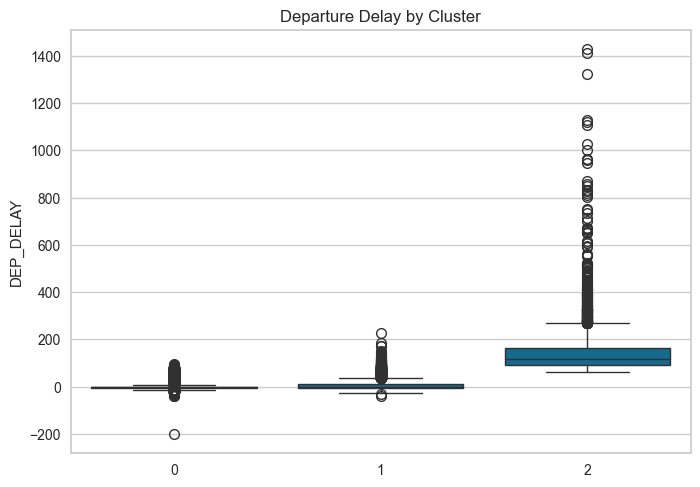

In [20]:
import seaborn as sns
sns.boxplot(x=kmeans.labels_, y=filtered_data['DEP_DELAY'])
plt.title('Departure Delay by Cluster')
plt.show()


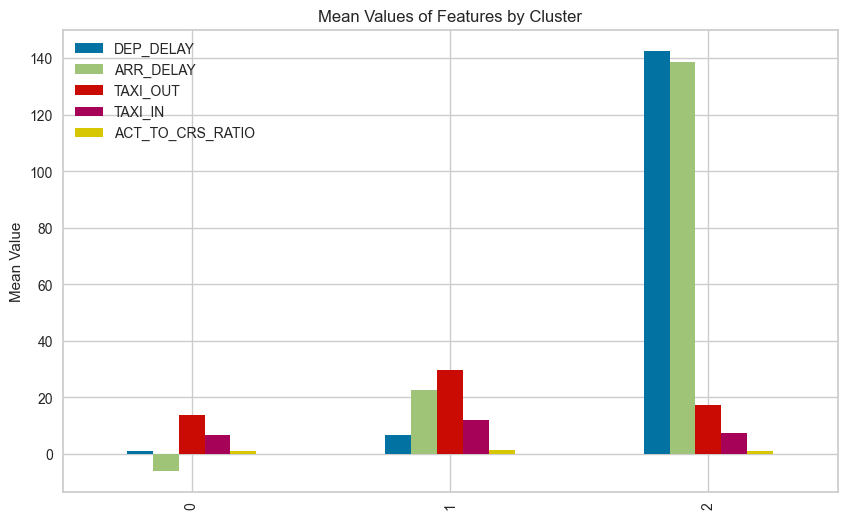

In [15]:
cluster_means = filtered_data.groupby(kmeans.labels_)[['DEP_DELAY', 'ARR_DELAY', 
                                                      'TAXI_OUT', 'TAXI_IN', 
                                                      'ACT_TO_CRS_RATIO']].mean()
cluster_means.plot(kind='bar', figsize=(10, 6))
plt.title('Mean Values of Features by Cluster')
plt.ylabel('Mean Value')
plt.show()


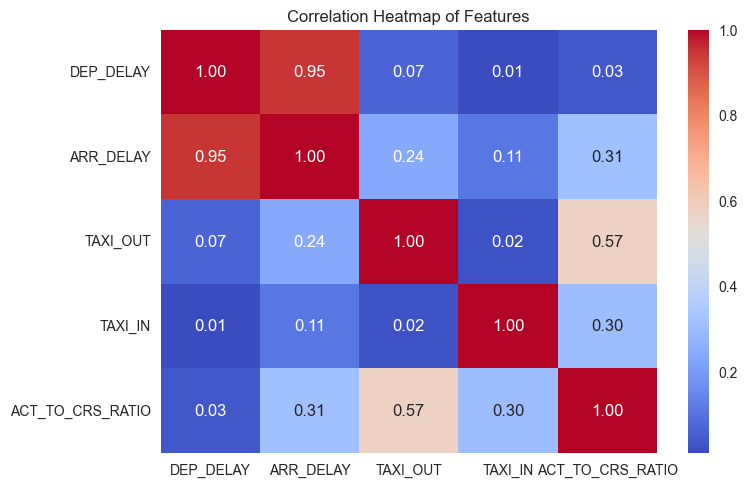

In [16]:
import seaborn as sns
correlation_matrix = filtered_data[['DEP_DELAY', 'ARR_DELAY', 
                                    'TAXI_OUT', 'TAXI_IN', 
                                    'ACT_TO_CRS_RATIO']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Features')
plt.show()


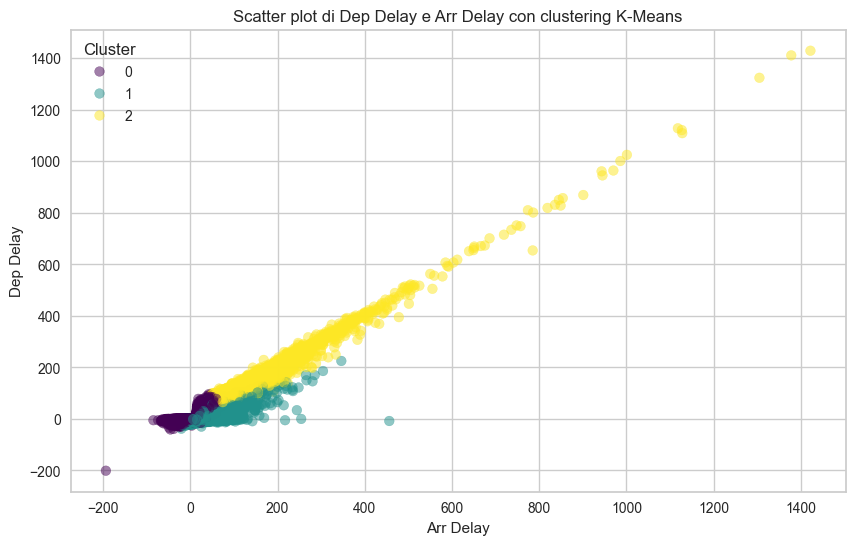

In [17]:
# Visualizza il grafico scatter di dep_delay e arr_delay con i cluster di K-Means
plt.figure(figsize=(10, 6))
scatter = plt.scatter(data['ARR_DELAY'], data['DEP_DELAY'], c=clusters, cmap='viridis', alpha=0.5)
plt.xlabel('Arr Delay')
plt.ylabel('Dep Delay')
plt.title('Scatter plot di Dep Delay e Arr Delay con clustering K-Means')

# Aggiungi una legenda per i cluster
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()

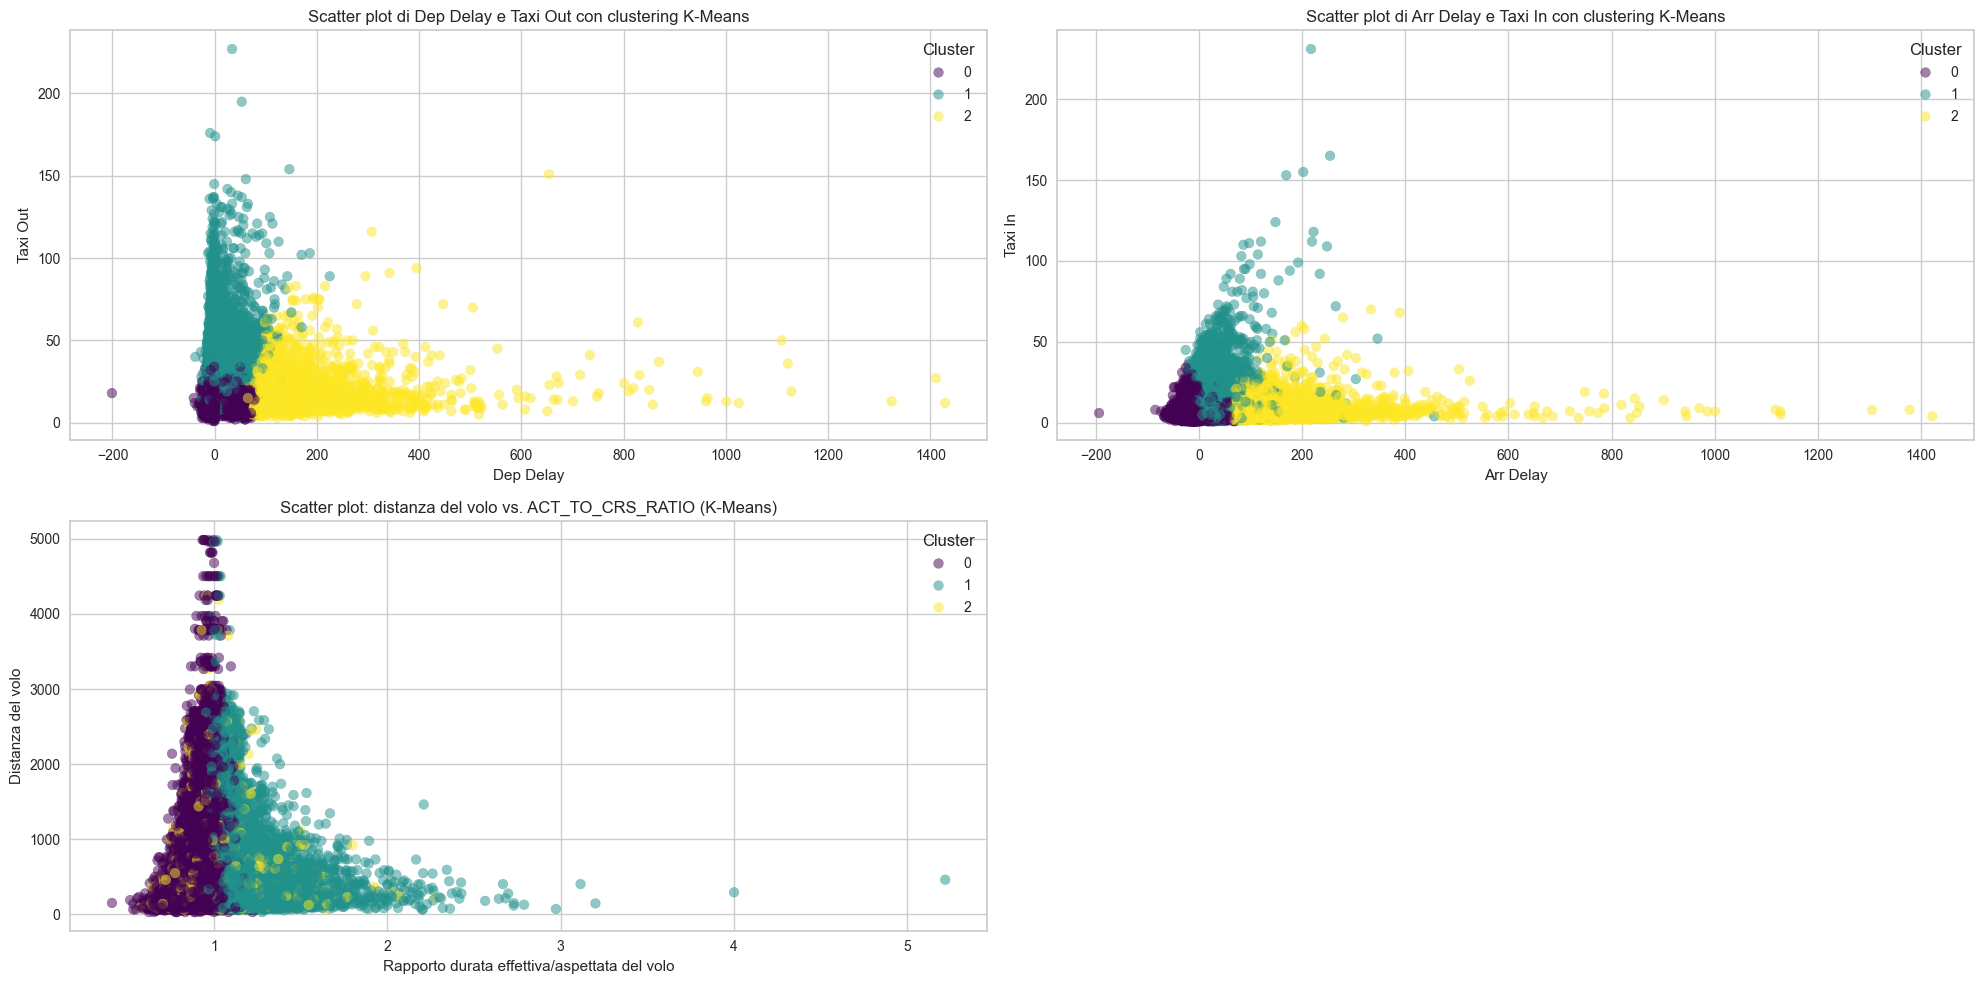

In [19]:
# Creazione della figura con due subplot
plt.figure(figsize=(20, 10))

# Primo grafico
plt.subplot(2, 2, 1)
plt.scatter(data['DEP_DELAY'], data['TAXI_OUT'], c=clusters, cmap='viridis', alpha=0.5)
plt.xlabel('Dep Delay')
plt.ylabel('Taxi Out')
plt.title('Scatter plot di Dep Delay e Taxi Out con clustering K-Means')
plt.legend(*scatter.legend_elements(), title="Cluster")

# Secondo grafico
plt.subplot(2, 2, 2)
plt.scatter(data['ARR_DELAY'], data['TAXI_IN'], c=clusters, cmap='viridis', alpha=0.5)
plt.xlabel('Arr Delay')
plt.ylabel('Taxi In')
plt.title('Scatter plot di Arr Delay e Taxi In con clustering K-Means')
plt.legend(*scatter.legend_elements(), title="Cluster")

# Terzo grafico
plt.subplot(2, 2, 3)
plt.scatter(data['ACT_TO_CRS_RATIO'], filtered_data['DISTANCE'], c=clusters, cmap='viridis', alpha=0.5)

# Etichette e titolo
plt.xlabel('Rapporto durata effettiva/aspettata del volo')
plt.ylabel('Distanza del volo')
plt.title('Scatter plot: distanza del volo vs. ACT_TO_CRS_RATIO (K-Means)')
plt.legend(*scatter.legend_elements(), title="Cluster")

# Mostra il grafico affiancato
plt.tight_layout()
plt.show()


C:\Users\dswal\AppData\Local\Temp\ipykernel_11040\2383834339.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Cluster'] = clusters


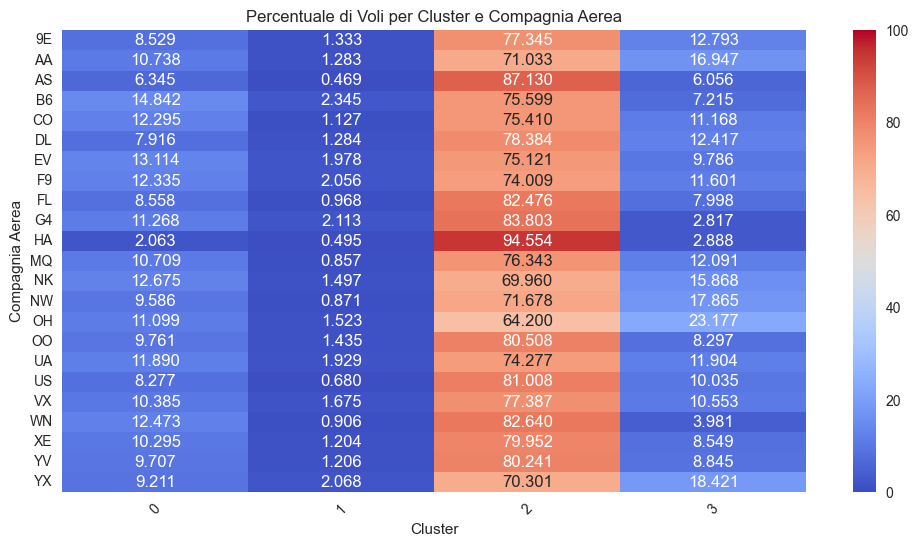

In [17]:
# Aggiungi i cluster come colonna a filtered_data
filtered_data['Cluster'] = clusters

# Creazione della tabella di contingenza (matrice)
contingency_table = pd.crosstab(filtered_data['OP_CARRIER'], filtered_data['Cluster'])

# Normalizzazione dei valori per ottenere percentuali
contingency_table_percent = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

# Creazione della heatmap con percentuali
plt.figure(figsize=(12, 6))
sns.heatmap(contingency_table_percent, annot=True, cmap='coolwarm', fmt='.3f', cbar=True, vmin=0, vmax=100)
plt.title('Percentuale di Voli per Cluster e Compagnia Aerea')
plt.xlabel('Cluster')
plt.ylabel('Compagnia Aerea')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


In [ ]:
# Calcola i campioni di silhouette per ciascun punto
silhouette_vals = silhouette_samples(pca_result, clusters)

# Calcola la silhouette media per l'intero clustering
silhouette_avg = silhouette_score(pca_result, clusters)

# Visualizza il grafico della silhouette
plt.figure(figsize=(10, 6))
y_lower = 10
n_clusters = len(set(clusters))

for i in range(n_clusters):
    # Accumula i valori di silhouette del cluster i e ordina i valori
    ith_cluster_silhouette_vals = silhouette_vals[clusters == i]
    ith_cluster_silhouette_vals.sort()
    
    y_upper = y_lower + len(ith_cluster_silhouette_vals)
    color = plt.cm.viridis(i / n_clusters)
    
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_vals,
                      facecolor=color, edgecolor=color, alpha=0.7)
    
    # Etichetta ogni silhouette con il rispettivo cluster al centro del grafico
    plt.text(-0.05, y_lower + 0.5 * len(ith_cluster_silhouette_vals), str(i))
    
    # Aggiorna y_lower per il prossimo cluster
    y_lower = y_upper + 10

# Linea verticale per la silhouette media dell'intero clustering
plt.axvline(x=silhouette_avg, color="red", linestyle="--")

plt.xlabel("Valore della silhouette")
plt.ylabel("Cluster")
plt.title("Grafico della silhouette per il clustering di K-Means")
plt.show()

# DBSCAN

In [7]:
# Calcola le distanze dai vicini più prossimi
k = 2 # Imposta 'k' uguale a min_samples.+-
neigh = NearestNeighbors(n_neighbors=k)
neighbors = neigh.fit(pca_result)
distances, indices = neighbors.kneighbors(pca_result)

# Ordina le distanze in ordine crescente
distances = np.sort(distances[:, 1], axis=0)  # Prendi solo la seconda colonna per la distanza dal 2° vicino

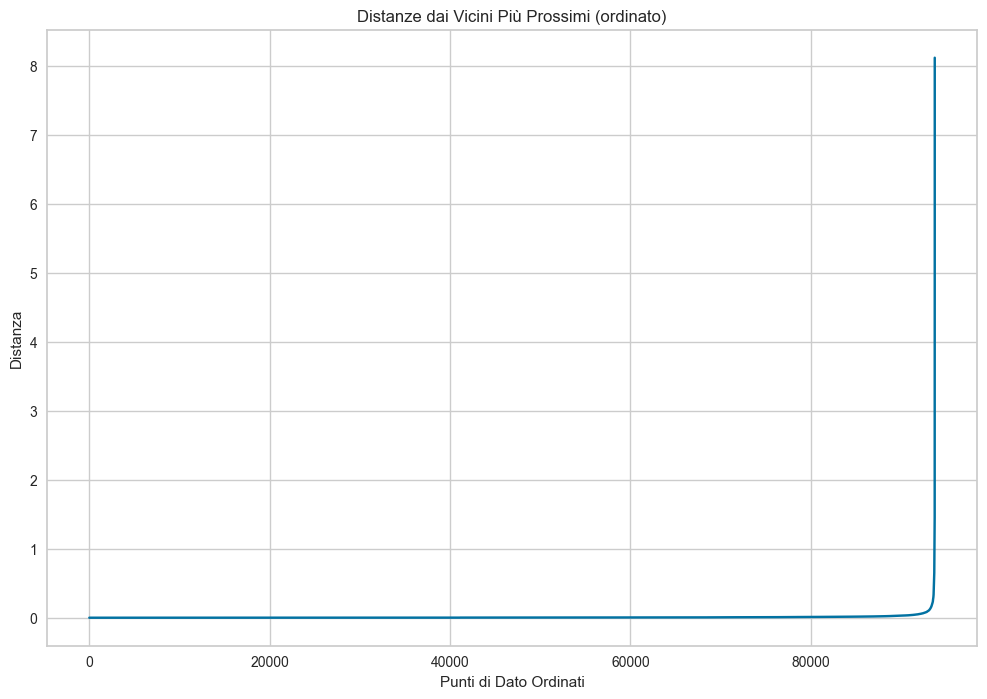

In [8]:
# Traccia il grafico per trovare il valore di epsilon
plt.figure(figsize=(12,8))
plt.plot(distances)
plt.title('Distanze dai Vicini Più Prossimi (ordinato)')
plt.xlabel('Punti di Dato Ordinati')
plt.ylabel('Distanza')
plt.grid(True)

y_ticks = np.arange(0, np.max(distances))
plt.yticks(y_ticks)

plt.show()

In [9]:
kneedle = KneeLocator(range(len(distances)), distances, curve="convex", direction="increasing")

# Epsilon è il valore della distanza al punto del ginocchio
epsilon = distances[kneedle.elbow]
print(f"Epsilon calcolato: {epsilon}")

Epsilon calcolato: 0.9284193089287094


In [10]:
# Esegui DBSCAN sui risultati della PCA
dbscan = DBSCAN(eps=epsilon, min_samples=k)  # Imposta eps e min_samples in base ai tuoi dati
dbscan_labels = dbscan.fit_predict(pca_result)

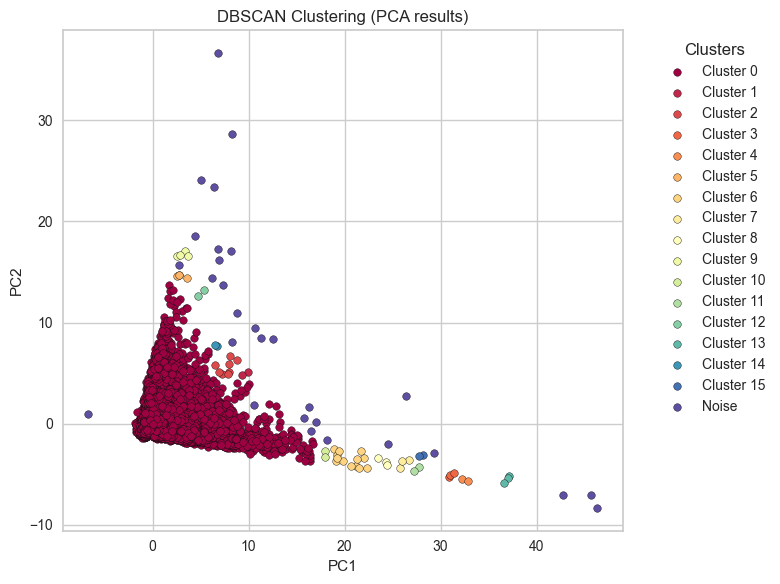

In [11]:
# Crea un grafico dei dati dopo l'applicazione della PCA
plt.figure(figsize=(8, 6))

# DBSCAN assegna -1 ai punti considerati "rumore"
unique_labels = set(dbscan_labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for i, col in zip(unique_labels, colors):
    class_member_mask = (dbscan_labels == i)
    xy = pca_result[class_member_mask]
    
    plt.scatter(xy[:, 0], xy[:, 1], s=30, c=[col], label=f"Cluster {i}" if i != -1 else 'Noise', edgecolors='k')

plt.title('DBSCAN Clustering (PCA results)')
plt.xlabel('PC1')
plt.ylabel('PC2')

# Aggiusta la posizione e la dimensione della legenda per migliorarne la leggibilità
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title="Clusters")

plt.tight_layout()  # Per evitare che la legenda si sovrapponga
plt.show()
